# Speak Feel: Data Quality Exploration 01   

**Bach Le, Kien Tran, Sauryanshu Khanal, Sike Ogieva**

Emotion Recognition has important applications in natural language processing and human computer interaction.
Here, we build and train a neural network to classify human speech data by emotion.   

Dataset:   
https://www.kaggle.com/datasets/uwrfkaggler/ravdess-emotional-speech-audio?resource=download

Project Milestones:   
https://github.com/sike25/speak_feel/blob/main/SpeakFeel_%20Emotion%20Recognition%20In%20Speech.pdf

---

In [1]:
!pip install audiomentations

In [2]:
import IPython.display as ipd
import librosa
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import plotly.express as px
import seaborn as sns

from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, Shift
from google.colab import drive
from sklearn.model_selection import train_test_split

**Data**

Our dataset (the speech-only subset of the RAVDESS) contains 1440 files: 60 trials per actor x 24 actors = 1440. There are 24 professional actors (12 female, 12 male), vocalizing two lexically-matched statements in a neutral North American accent. Speech emotions includes calm, happy, sad, angry, fearful, surprise, and disgust expressions. Each expression is produced at two levels of emotional intensity (normal, strong), with an additional neutral expression.

In [3]:
drive.mount('/content/drive')
RAV = '/content/drive/My Drive/data/ravdess-emotional-speech-audio/audio_speech_actors_01-24/'
dir_list = os.listdir(RAV)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# local directory path
# RAV = 'ravdess-emotional-speech-audio/audio_speech_actors_01-24/'
dir_list = os.listdir(RAV)

emotion, intensity, statement, repetition, actor, gender, name, paths = [], [], [], [], [], [], [], []

emotion_list   = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgusted', 'surprised']
intensity_list = ['normal', 'strong']
statement_list = ['kids', 'dogs']
gender_list = ['male', 'female']

for dir in dir_list:
    files = os.listdir(RAV + dir)

    for file in files:
        parts = file.split('.')[0].split('-')

        name.append(file)
        emotion.append(emotion_list[int(parts[2]) - 1])
        intensity.append(intensity_list[int(parts[3]) - 1])
        statement.append(statement_list[int(parts[4]) - 1])
        repetition.append(int(parts[5]))
        actor.append(int(parts[6]))

        temp = int(parts[6])
        if temp % 2 == 0:
            temp = gender_list[1]
        else:
            temp = gender_list[0]
        gender.append(temp)
        paths.append(RAV + dir + '/' + file)

In [5]:
data = {
    'File Name': name,
    'Emotion': emotion,
    'Intensity': intensity,
    'Statement': statement,
    'Repetition': repetition,
    'Actor': actor,
    'Gender': gender,
}

df = pd.DataFrame(data)
print(df.shape)
df.head()

(1440, 7)


,File Name,Emotion,Intensity,Statement,Repetition,Actor,Gender
0,03-01-01-01-02-01-19.wav,neutral,normal,dogs,1,19,male
1,03-01-02-01-02-02-19.wav,calm,normal,dogs,2,19,male
2,03-01-02-02-02-01-19.wav,calm,strong,dogs,1,19,male
3,03-01-01-01-01-02-19.wav,neutral,normal,kids,2,19,male
4,03-01-02-01-01-01-19.wav,calm,normal,kids,1,19,male


**Exploratory Data Analysis**  

We want to know how well our data is distributed amongst all of the possible target variable. In other words, is there any class which is under/overrepresented?  
> We find that the neutral data points are half as few as the others. The data card explains this is because it only contains normal intensities (while the others contain both normal and strong).

In [6]:
px_fig = px.histogram(df, x='Emotion', color='Emotion', title='Distribution of Target Variables in Our Dataset')
px_fig.update_layout(bargap=0.1)
px_fig.show()

Then, we check the distribution of the other features, to make sure our data points are reasonably distributed among the different genders, intensities, actors and statements.  
> Spoiler: They are.

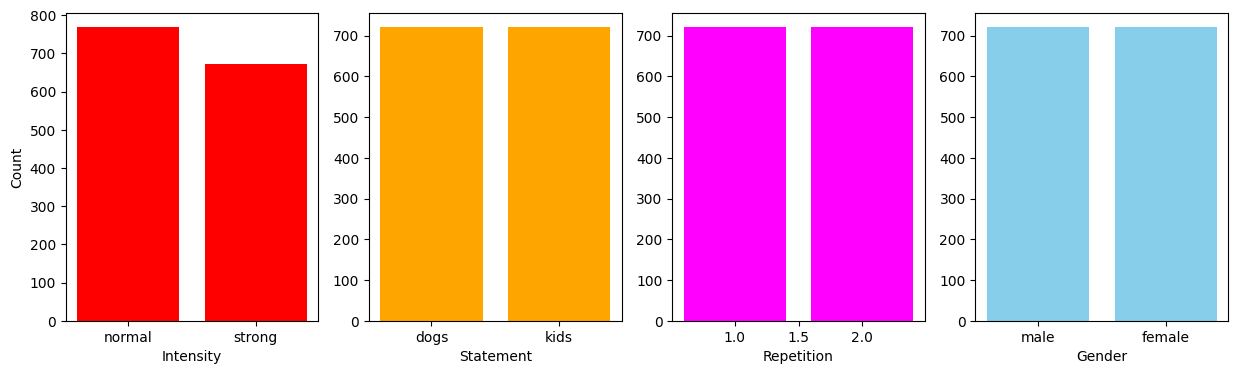

In [7]:
intensity_counts  = df['Intensity'].value_counts()
statement_counts  = df['Statement'].value_counts()
repetition_counts = df['Repetition'].value_counts()
gender_counts     = df['Gender'].value_counts()

feature_counts = [intensity_counts, statement_counts, repetition_counts, gender_counts]

colors   = ['red', 'orange', 'magenta', 'skyblue']
features = ['Intensity', 'Statement', 'Repetition', 'Gender']

fig, axs = plt.subplots(1, 4, figsize=(15, 4))

for i in range(4):
    axs[i].bar(feature_counts[i].index, feature_counts[i].values, color=colors[i])
    axs[i].set_xlabel(features[i])
axs[0].set_ylabel('Count')

plt.show()


What about WITHIN each target variable? Are 80% of all disgusted files spoken by women? Or are the features reasonably distributed among the emotions? Let us see.   
> Our analysis finds perfect distributions.

In [8]:
def printDistributionOfFeatures(emotion, sub_df):
    intensity_counts  = sub_df['Intensity'].value_counts()
    statement_counts  = sub_df['Statement'].value_counts()
    repetition_counts = sub_df['Repetition'].value_counts()
    gender_counts     = sub_df['Gender'].value_counts()
    actor_counts      = sub_df['Actor'].value_counts()
    print(f"Distribution of features in {emotion} subset")
    print(intensity_counts.values, statement_counts.values, repetition_counts.values, gender_counts.values, actor_counts.values)

emotions = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgusted', 'surprised']
for i in range(8):
    sub_df = df[df['Emotion'] == emotions[i]]
    printDistributionOfFeatures(emotions[i], sub_df)
    print()

Distribution of features in neutral subset
[96] [48 48] [48 48] [48 48] [4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]

Distribution of features in calm subset
[96 96] [96 96] [96 96] [96 96] [8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8]

Distribution of features in happy subset
[96 96] [96 96] [96 96] [96 96] [8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8]

Distribution of features in sad subset
[96 96] [96 96] [96 96] [96 96] [8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8]

Distribution of features in angry subset
[96 96] [96 96] [96 96] [96 96] [8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8]

Distribution of features in fearful subset
[96 96] [96 96] [96 96] [96 96] [8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8]

Distribution of features in disgusted subset
[96 96] [96 96] [96 96] [96 96] [8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8]

Distribution of features in surprised subset
[96 96] [96 96] [96 96] [96 96] [8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8]



**Audio File Quality**

Now, we want to know whether there are enough differences in the audio such as frequency, amplitude, troughs and crests etc, across different labels  such that a good model can find features to differentiate on.  We use spectrograms and wave plots to answer this question.  
> We find substantial differences across audio files of different emotions.

Let us begin with wave plots.

In [9]:
"""
Create a waveplot of a given wav file
Params: data (from librosa documentation https://librosa.org/doc/main/generated/librosa.load.html, a time-series of floating point numbers representing the audio file)
        sr, Sampling Rate
        ax, Axes on the main plot
        filter: Any one value from emotion, or statement or any other attribute
"""
def create_waveplot(data, sr, ax, attribute, value):
    ax.set_title(f'{attribute.capitalize()}: {value}', size=10)
    librosa.display.waveshow(data, sr=sr, ax=ax)

def create_waveplot_wrapper(df, attribute, value, ax):
    sample_obs = df[df[attribute] == value].iloc[0]
    sample_path = paths[sample_obs.name]
    data, sampling_rate = librosa.load(sample_path)
    create_waveplot(data, sampling_rate, ax, attribute, value)

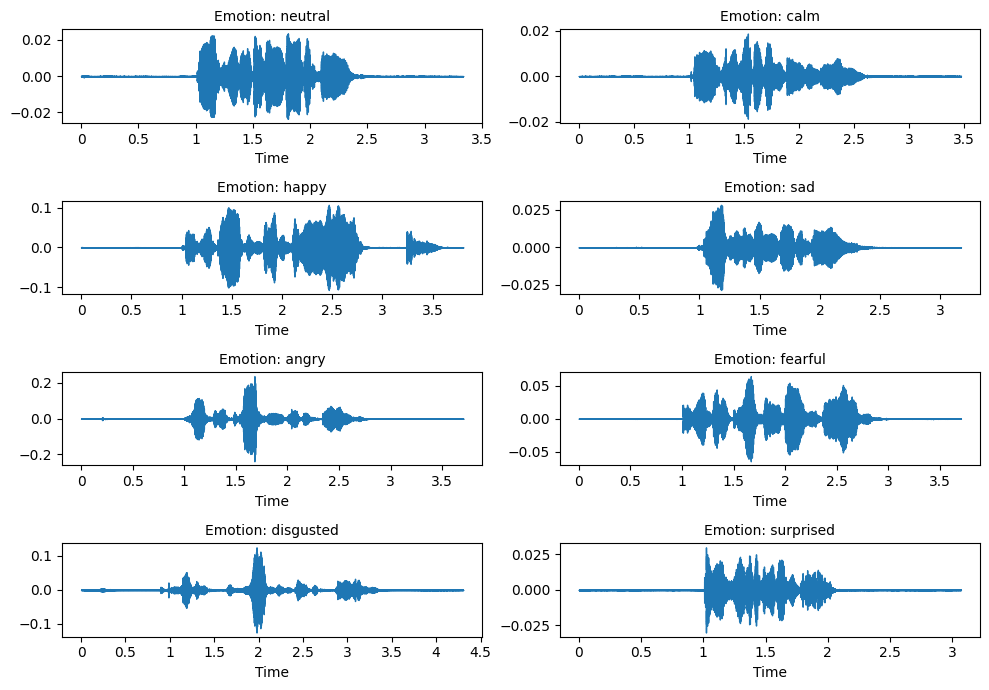

In [10]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(10, 7))
axes = axes.flatten()
for i, emotion in enumerate(emotion_list):
    create_waveplot_wrapper(df, 'Emotion', emotion, axes[i])
plt.tight_layout()
plt.show()

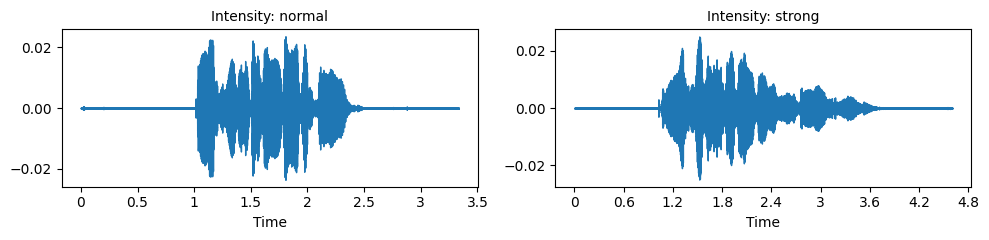

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 2.5))
axes = axes.flatten()
for i, intensity in enumerate(intensity_list):
    create_waveplot_wrapper(df, 'Intensity', intensity, axes[i])
plt.tight_layout()
plt.show()

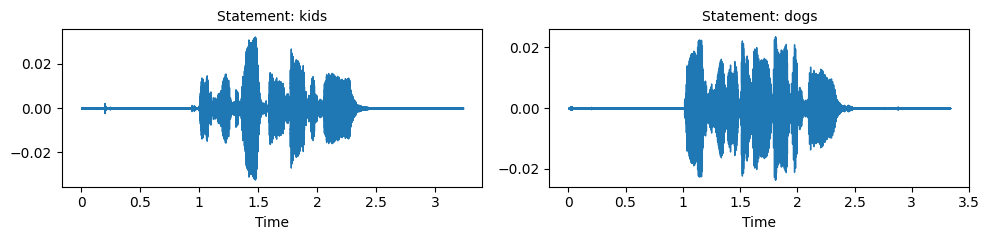

In [12]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 2.5))
axes = axes.flatten()
for i, statement in enumerate(statement_list):
    create_waveplot_wrapper(df, 'Statement', statement, axes[i])
plt.tight_layout()
plt.show()

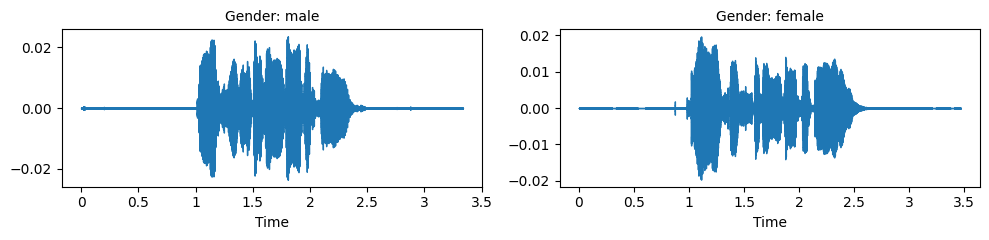

In [13]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 2.5))
axes = axes.flatten()
for i, gender in enumerate(gender_list):
    create_waveplot_wrapper(df, 'Gender', gender, axes[i])
plt.tight_layout()
plt.show()

Now, we look at the spectrograms.

In [14]:
"""
Create a spectogram of a given wav file
Params: data (from librosa documentation https://librosa.org/doc/main/generated/librosa.load.html, a time-series of floating point numbers representing the audio file)
        sr, Sampling Rate
        filter: Any one value from emotion, or statement or any other attribute
"""
def create_spectrogram_wrapper(attribute, value, ax):
  sample_obs = df[df[attribute] == value].iloc[0]
  sample_path = paths[sample_obs.name]
  data, sampling_rate = librosa.load(sample_path)
  create_spectrogram(data, sampling_rate, attribute, value, ax)

def create_spectrogram(data, sr, attribute, value, ax):
    # The STFT represents a signal in the time-frequency domain by computing
    # discrete Fourier transforms (DFT) over short overlapping windows
    X = librosa.stft(data) # Source and Example of usage: https://librosa.org/doc/main/generated/librosa.stft.html
    Xdb = librosa.amplitude_to_db(abs(X))
    ax.set_title(f'Spectogram for audio with {attribute}={value}', size=15)
    librosa.display.specshow(Xdb, sr = sr, x_axis = 'time', y_axis = 'hz', ax = ax)

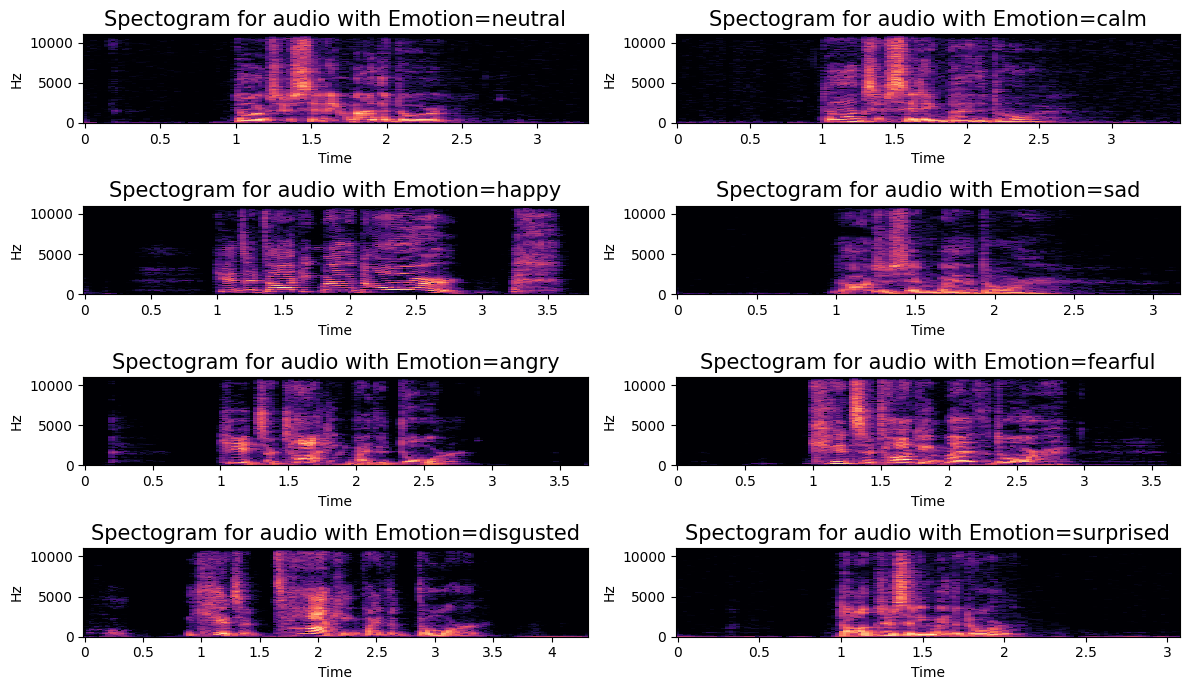

In [15]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(12, 7))
axes = axes.flatten()
for i, emotion in enumerate(emotion_list):
    create_spectrogram_wrapper('Emotion', emotion, axes[i])
plt.tight_layout()
plt.show()

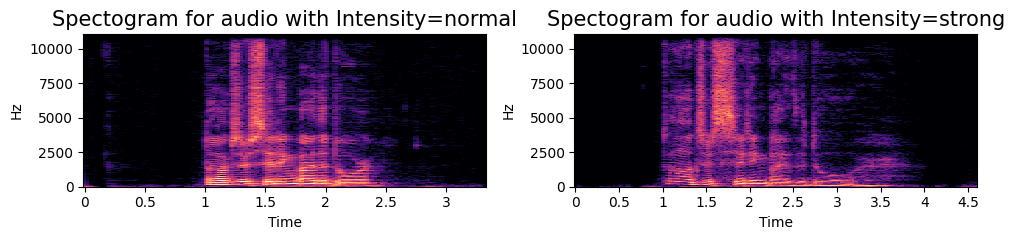

In [16]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 2.5))
axes = axes.flatten()
for i, intensity in enumerate(intensity_list):
    create_spectrogram_wrapper('Intensity', intensity, axes[i])
plt.tight_layout()
plt.show()

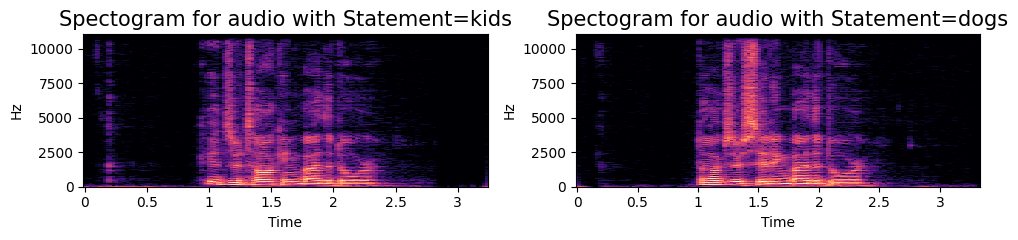

In [17]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 2.5))
axes = axes.flatten()
for i, statement in enumerate(statement_list):
    create_spectrogram_wrapper('Statement', statement, axes[i])
plt.tight_layout()
plt.show()

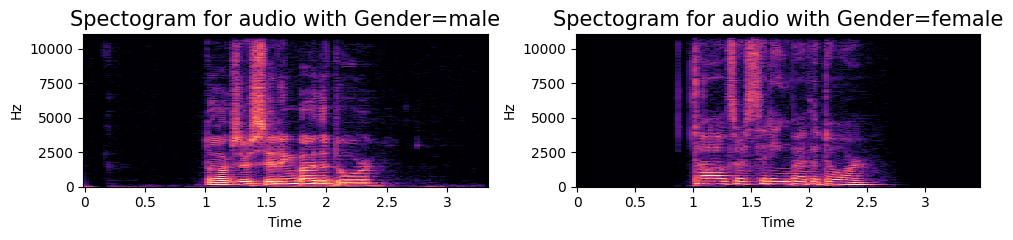

In [18]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 2.5))
axes = axes.flatten()
for i, gender in enumerate(gender_list):
    create_spectrogram_wrapper('Gender', gender, axes[i])
plt.tight_layout()
plt.show()

**Data Augmentation**

Data augmentation is a technique used to enhance the size and variance of data sets by artificially creating variations of existing samples. In audio, common data augmentation techniques are applying noise, stretch, time shifts and pitch changes.  
These transformations help models generalize better by providing more training data and simulating different acoustic environments and recording conditions that might not be adequately represented in the original dataset.  

We start by trying the transformations with a single audio file, to ensure they are reasonable.

In [19]:
augment_noise   = AddGaussianNoise(min_amplitude = 0.001, max_amplitude = 0.002, p = 1)# p = 1
augment_stretch = TimeStretch(min_rate = 0.8, max_rate = 1.25, p = 1)
augment_pitch   = PitchShift(min_semitones = -4, max_semitones = 4, p = 1)
augment_shift   = Shift(p = 1)

augment = Compose([
    AddGaussianNoise(min_amplitude = 0.001, max_amplitude = 0.002, p = 0.5), # p = 0.5
    TimeStretch(min_rate = 0.8, max_rate = 1.25, p = 0.5),
    PitchShift(min_semitones = -4, max_semitones = 4, p = 0.5),
    Shift(p = 0.5),
])

In [25]:
data, sample_rate = librosa.load(paths[0])

noisy_data     = augment_noise(samples = data, sample_rate = sample_rate)
stretched_data = augment_stretch(samples = data, sample_rate = sample_rate)
shifted_data   = augment_shift(samples = data, sample_rate = sample_rate)
pitched_data   = augment_pitch(samples = data, sample_rate = sample_rate)

print("Original:")
ipd.display(ipd.Audio(data, rate=sample_rate))
print("Noisy:")
ipd.display(ipd.Audio(noisy_data, rate=sample_rate))
print("Time-stretched:")
ipd.display(ipd.Audio(stretched_data, rate=sample_rate))
print("Shifted:")
ipd.display(ipd.Audio(shifted_data, rate=sample_rate))
print("Pitch-shifted:")
ipd.display(ipd.Audio(pitched_data, rate=sample_rate))

Original:


Noisy:


Time-stretched:


Shifted:


Pitch-shifted:


Before we proceed to the augmentation of the entire dataset, we split the test and training data, so we do not make the mistake of training our model on variations of the test data.

In [21]:
audio_files = []
for i, path in enumerate(paths):
    audio_files.append(librosa.load(path))

X = pd.DataFrame({'Audio': audio_files})
y = df['Emotion']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

Then we run the code on the training data.

In [22]:
def audio_generator(file_paths, batch_size):
    while True:
        batch_paths = np.random.choice(a = file_paths, size = batch_size)
        batch_features, batch_labels = [], []

        for path in batch_paths:
            audio, sample_rate = librosa.load(path)
            augmented_audio = augment(samples = audio, sample_rate = sample_rate)
            augmented_audio = ipd.Audio(augmented_audio, rate=sample_rate)
            batch_features.append(augmented_audio)

            fileName = os.path.basename(path)
            parts = fileName.split('.')[0].split('-')
            batch_labels.append(emotion_list[int(parts[2]) - 1])

        yield np.array(batch_features), np.array(batch_labels)

batch_size = 24
gen = audio_generator(file_paths = paths, batch_size = batch_size)

In [23]:
new_data, new_labels = np.array([]), np.array([])

for i in range(144):
    batch_data, batch_labels = next(gen)
    new_data   = np.concatenate((new_data,   batch_data), axis=0)
    new_labels = np.concatenate((new_labels, batch_labels), axis=0)

len(new_data), len(new_labels)

(3456, 3456)

In [24]:
ipd.display(new_data[42])
print(new_labels[42])

surprised


**Citations:**

Data collected from
"The Ryerson Audio-Visual Database of Emotional Speech and Song (RAVDESS)" by Livingstone & Russo is licensed under CC BY-NA-SC 4.0.   
https://github.com/iver56/audiomentations   
https://librosa.org/doc/main/generated/librosa.stft.html    
https://librosa.org/doc/main/generated/librosa.load.html   